In [7]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder


In [3]:
# Load the data
file_path = "../data/save.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Remove duplicates
data = data.drop_duplicates()

# Display the first few rows for verification
print(data.head())

# Convert the stringified dictionary in 'metadata' to a proper dictionary
data['metadata'] = data['metadata'].apply(ast.literal_eval)
# Extract metadata fields into separate columns
metadata_df = pd.json_normalize(data['metadata'])
data = pd.concat([data.drop(columns=['metadata']), metadata_df], axis=1)
data['terrain_encoded'] = data['terrain'].astype('category').cat.codes


   Unnamed: 0   ai_pred  huma_pred  mines  \
0           0  0.294552   0.217046    1.0   
1           1  0.085612   0.131810    1.0   
2           2  0.119203   0.108941    1.0   
3           3  0.119203   0.108941    1.0   
4           4  0.449078   0.339858    1.0   

                                            metadata  
0  {'terrain': 'Sandy', 'time': 6, 'temperature':...  
1  {'terrain': 'Sandy', 'time': 6, 'temperature':...  
2  {'terrain': 'Grassy', 'time': 6, 'temperature'...  
3  {'terrain': 'Grassy', 'time': 6, 'temperature'...  
4  {'terrain': 'Swampy', 'time': 6, 'temperature'...  


In [8]:
# Ensure terrain is encoded
terrain_codes = data['terrain_encoded'].values
n_terrains = len(data['terrain_encoded'].unique())

continuous_vars = ['temperature', 'wind_speed', 'visibility', 'precipitation']
for var in continuous_vars:
    mean = data[var].mean()
    std = data[var].std()
    data[f'{var}_std'] = (data[var] - mean) / std  # Use training mean and std


with pm.Model() as model:
    # Hyperpriors for terrain effect
    terrain_mu = pm.Normal('terrain_mu', mu=0, sigma=1)
    terrain_sigma = pm.HalfNormal('terrain_sigma', sigma=1)
    # Non-centered parameterization
    terrain_effect_raw = pm.Normal('terrain_effect_raw', mu=0, sigma=1, shape=n_terrains)
    terrain_effect = pm.Deterministic('terrain_effect', terrain_mu + terrain_effect_raw * terrain_sigma)
    
    # Priors for standardized metadata variables
    beta_temp = pm.Normal("beta_temp", mu=0, sigma=1)
    beta_wind = pm.Normal("beta_wind", mu=0, sigma=1)
    beta_visibility = pm.Normal("beta_visibility", mu=0, sigma=1)
    beta_precip = pm.Normal("beta_precip", mu=0, sigma=10)

    # Intercept
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    # Noise term
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Linear model
    ai_accuracy = (
        intercept +
        beta_temp * data["temperature_std"] +
        beta_wind * data["wind_speed_std"] +
        beta_visibility * data["visibility_std"] +
        beta_precip * data["precipitation_std"] +
        terrain_effect[terrain_codes]
    )

    # Likelihood
    AI_accuracy_obs = pm.Normal("AI_accuracy_obs", mu=ai_accuracy, sigma=sigma, observed=data["ai_pred"])

    # Sampling
    trace = pm.sample(
        draws=1000,
        tune=1000,
        #target_accept=0.95,
        nuts_sampler_kwargs={'max_treedepth': 25},
        
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [terrain_mu, terrain_sigma, terrain_effect_raw, beta_temp, beta_wind, beta_visibility, beta_precip, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 138 seconds.


In [9]:
def build_and_fit_model(train_data, n_terrains):
    with pm.Model() as model:
        # Data containers for variables (allows us to update them later)
        temperature = pm.Data('temperature', train_data["temperature_std"])
        wind_speed = pm.Data('wind_speed', train_data["wind_speed_std"])
        visibility = pm.Data('visibility', train_data["visibility_std"])
        precipitation = pm.Data('precipitation', train_data["precipitation_std"])
        terrain_codes = pm.Data('terrain_codes', train_data['terrain_encoded'])
        mines_binary = pm.Data('mines_binary', train_data["mines_binary"])
        ai_pred = pm.Data('ai_pred', train_data["ai_pred"])

        # Hyperpriors for terrain effect
        terrain_mu = pm.Normal('terrain_mu', mu=0, sigma=1)
        terrain_sigma = pm.HalfNormal('terrain_sigma', sigma=1)

        # Non-centered parameterization
        terrain_effect_raw = pm.Normal('terrain_effect_raw', mu=0, sigma=1, shape=n_terrains)
        terrain_effect = pm.Deterministic('terrain_effect', terrain_mu + terrain_effect_raw * terrain_sigma)

        # Priors for standardized metadata variables
        beta_temp = pm.Normal("beta_temp", mu=0, sigma=1)
        beta_wind = pm.Normal("beta_wind", mu=0, sigma=1)
        beta_visibility = pm.Normal("beta_visibility", mu=0, sigma=1)
        beta_precip = pm.Normal("beta_precip", mu=0, sigma=1)
        beta_mines = pm.Normal("beta_mines", mu=0, sigma=1)  # Coefficient for 'mines'

        # Intercept
        intercept = pm.Normal("intercept", mu=0, sigma=1)

        # Noise term
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Linear model
        ai_accuracy = (
            intercept +
            beta_temp * temperature +
            beta_wind * wind_speed +
            beta_visibility * visibility +
            beta_precip * precipitation +
            beta_mines * mines_binary +  # Include 'mines_binary' in the model
            terrain_effect[terrain_codes]
        )

        # Likelihood
        AI_accuracy_obs = pm.Normal("AI_accuracy_obs", mu=ai_accuracy, sigma=sigma, observed=ai_pred)

        # Sampling
        trace = pm.sample(
            draws=1000,
            tune=1000,
            nuts_sampler_kwargs={'max_treedepth': 25},
            progressbar=True
        )

    return model, trace


In [12]:
output_file = "cross_validation_predictions.csv"

# Create or overwrite the file with headers
pd.DataFrame(columns=["fold", "true_value", "predicted_value"]).to_csv(output_file, index=False)

# Number of folds
K = 2

# Prepare cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Initialize list to store RMSE for each fold
fold_results = []

fold = 1
for train_index, test_index in kf.split(data):
    print(f"Fold {fold}")
    # Split the data into training and validation sets
    train_data = data.iloc[train_index].reset_index(drop=True)
    test_data = data.iloc[test_index].reset_index(drop=True)

    train_data['mines_binary'] = train_data['mines'] - 1
    test_data['mines_binary'] = test_data['mines'] - 1


    # Standardize continuous variables using training data statistics
    continuous_vars = ['temperature', 'wind_speed', 'visibility', 'precipitation']
    for var in continuous_vars:
        mean = train_data[var].mean()
        std = train_data[var].std()
        train_data[f'{var}_std'] = (train_data[var] - mean) / std
        test_data[f'{var}_std'] = (test_data[var] - mean) / std  # Use training mean and std

    # Encode terrain categories
    terrain_categories = train_data['terrain'].astype('category').cat.categories
    train_data['terrain_encoded'] = train_data['terrain'].astype('category').cat.codes
    test_data['terrain_encoded'] = test_data['terrain'].astype('category').cat.set_categories(terrain_categories).cat.codes

    n_terrains = len(terrain_categories)

    # Build and fit the model on training data
    model, trace = build_and_fit_model(train_data, n_terrains)

    # Update the data in the model to use the test set
    with model:
        pm.set_data({
            'temperature': test_data["temperature_std"],
            'wind_speed': test_data["wind_speed_std"],
            'visibility': test_data["visibility_std"],
            'precipitation': test_data['precipitation_std'],
            'terrain_codes': test_data['terrain_encoded'],
            'mines_binary': test_data["mines_binary"],  # Include 'mines_binary' for prediction
            'ai_pred': test_data["ai_pred"]
        })

        # Sample from the posterior predictive distribution
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['AI_accuracy_obs'], progressbar=True)
    # Compute RMSE for the current fold
    y_true = test_data['ai_pred'].values
    y_pred = posterior_predictive['posterior_predictive']['AI_accuracy_obs'].values
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    print(f"Fold {fold} RMSE: {rmse}\n")
    fold_results.append(rmse)

    '''# Save predictions and true values to CSV
    results_df = pd.DataFrame({
        "fold": [fold] * len(y_true),
        "true_value": y_true,
        "predicted_value": y_pred
    })
    results_df.to_csv(output_file, mode="a", header=False, index=False)'''

    fold += 1

# Aggregate results
mean_rmse = np.mean(fold_results)
print(f"Cross-validated RMSE: {mean_rmse}")

Fold 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [terrain_mu, terrain_sigma, terrain_effect_raw, beta_temp, beta_wind, beta_visibility, beta_precip, beta_mines, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
Sampling: [AI_accuracy_obs]


Output()

Fold 1 RMSE: 0.27333793995863576

Fold 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [terrain_mu, terrain_sigma, terrain_effect_raw, beta_temp, beta_wind, beta_visibility, beta_precip, beta_mines, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [AI_accuracy_obs]


Output()

Fold 2 RMSE: 0.2752546420191769

Cross-validated RMSE: 0.2742962909889063


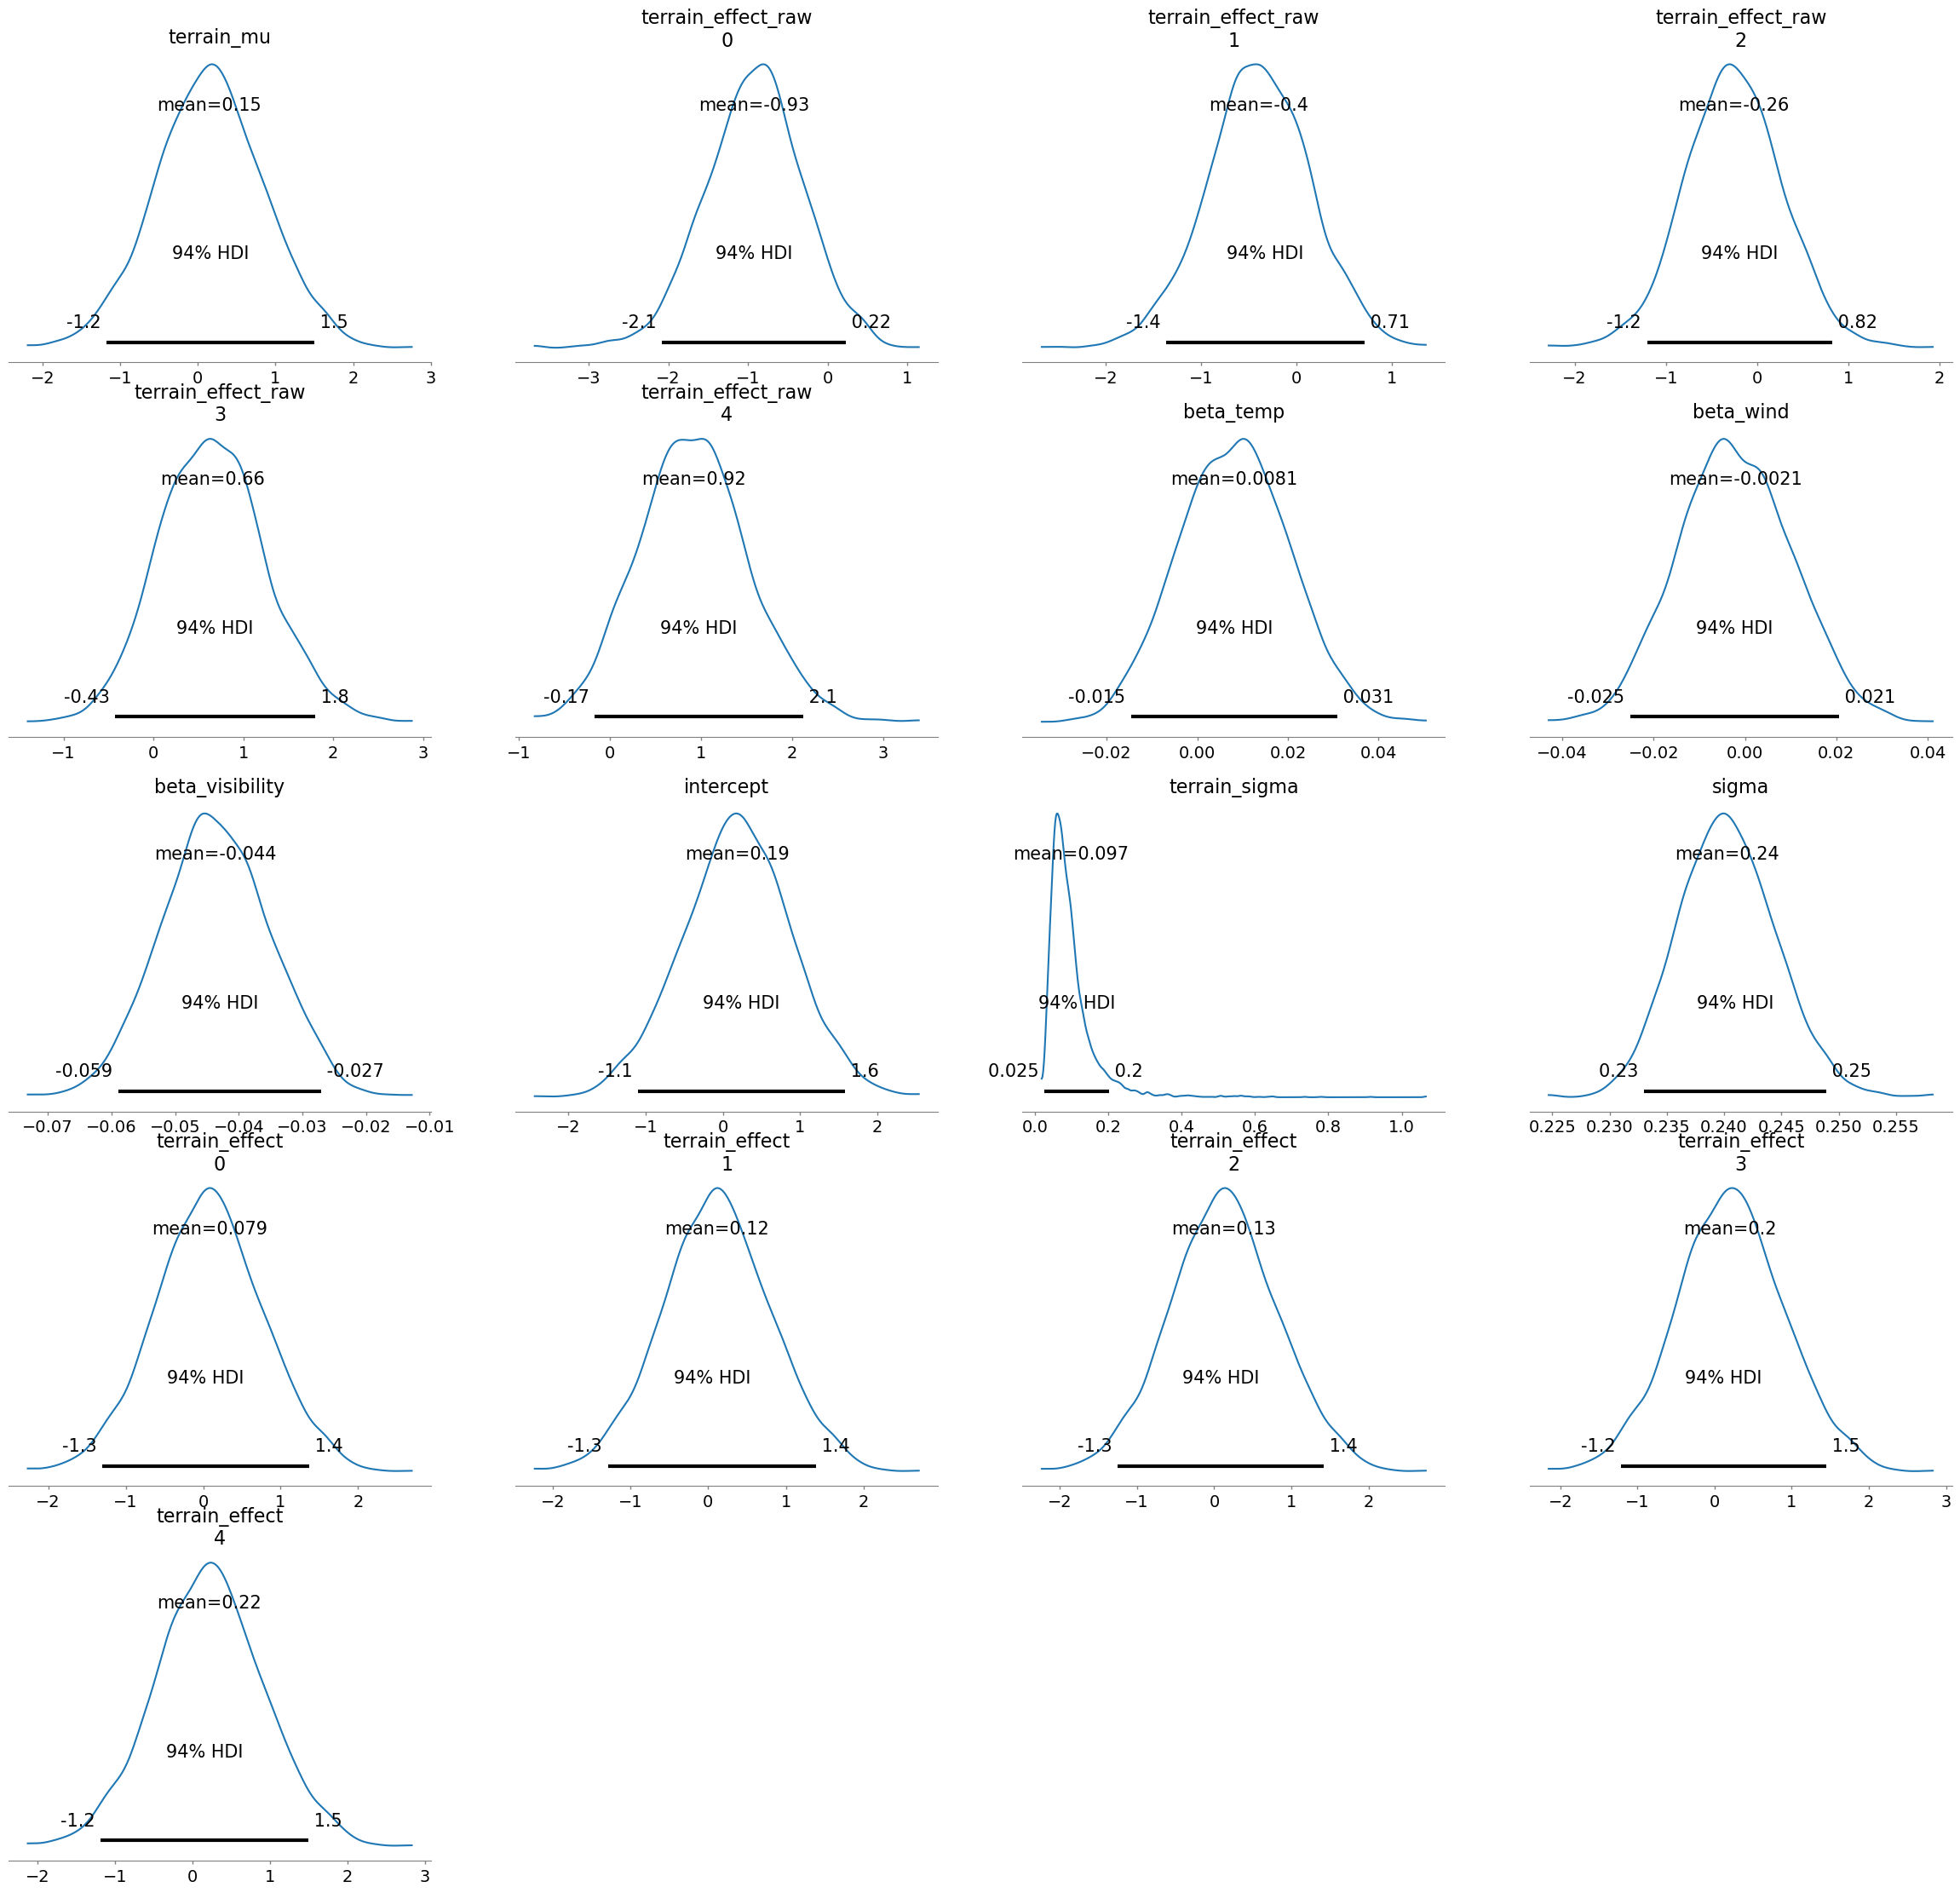

In [32]:
# Summary of posterior distributions
az.summary(trace)

# Posterior plots
az.plot_posterior(trace)
plt.show()

In [11]:
# Number of folds
K = 2

# Prepare cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Initialize list to store RMSE for the naive mean predictor
naive_mean_fold_results = []

for train_index, test_index in kf.split(data):
    # Split the data
    train_data = data.iloc[train_index].reset_index(drop=True)
    test_data = data.iloc[test_index].reset_index(drop=True)

    # Compute the mean of 'ai_pred' in the training set
    mean_ai_pred = train_data['ai_pred'].mean()

    # Predict the mean for all instances in the test set
    y_true = test_data['ai_pred'].values
    y_pred_naive_mean = np.full_like(y_true, fill_value=mean_ai_pred)

    # Compute RMSE for the naive mean predictor
    rmse_naive_mean = np.sqrt(np.mean((y_pred_naive_mean - y_true) ** 2))
    naive_mean_fold_results.append(rmse_naive_mean)

# Aggregate results
mean_rmse_naive_mean = np.mean(naive_mean_fold_results)
print(f"Cross-validated RMSE (Naive Mean Predictor): {mean_rmse_naive_mean}")


Cross-validated RMSE (Naive Mean Predictor): 0.25657347775927053


In [10]:
# Number of folds
K = 2

# Prepare cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Initialize list to store RMSE for the linear regression with "mines"
lr_with_mines_fold_results = []

for train_index, test_index in kf.split(data):
    # Split the data
    train_data = data.iloc[train_index].reset_index(drop=True)
    test_data = data.iloc[test_index].reset_index(drop=True)

    # Standardize continuous variables
    continuous_vars = ['temperature', 'wind_speed', 'visibility', 'precipitation']
    for var in continuous_vars:
        mean = train_data[var].mean()
        std = train_data[var].std()
        train_data[f'{var}_std'] = (train_data[var] - mean) / std
        test_data[f'{var}_std'] = (test_data[var] - mean) / std

    # Convert 'mines' to binary (0 for no mine, 1 for mine present)
    train_data['mines_binary'] = train_data['mines'] - 1
    test_data['mines_binary'] = test_data['mines'] - 1

    # Prepare features (include 'mines_binary')
    feature_cols = [f"{var}_std" for var in continuous_vars] + ['mines_binary']
    X_train = train_data[feature_cols]
    y_train = train_data['ai_pred']
    X_test = test_data[feature_cols]
    y_test = test_data['ai_pred']

    # Train the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred_lr_mines = lr_model.predict(X_test)

    # Compute RMSE
    rmse_lr_mines = np.sqrt(np.mean((y_pred_lr_mines - y_test) ** 2))
    lr_with_mines_fold_results.append(rmse_lr_mines)

# Aggregate results
mean_rmse_lr_with_mines = np.mean(lr_with_mines_fold_results)
print(f"Cross-validated RMSE: {mean_rmse_lr_with_mines}")


Cross-validated RMSE: 0.19687361861561578


In [19]:
from scipy.stats import ttest_rel

# Compare Bayesian model and linear regression with 'mines'
t_stat_bayes_lr, p_value_bayes_lr = ttest_rel(fold_results, lr_with_mines_fold_results)
print(f"Paired t-test between Bayesian and LR: t-statistic={t_stat_bayes_lr:.3f}, p-value={p_value_bayes_lr:.3f}")


Paired t-test between Bayesian and LR: t-statistic=23.056, p-value=0.028


In [9]:

# Number of folds
K = 2

# Prepare cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Initialize list to store RMSE for the linear regression with "mines"
lr_with_mines_fold_results = []

for train_index, test_index in kf.split(data):
    # Split the data
    train_data = data.iloc[train_index].reset_index(drop=True)
    test_data = data.iloc[test_index].reset_index(drop=True)

    # Standardize continuous variables
    continuous_vars = ['temperature', 'wind_speed', 'visibility', 'precipitation']
    for var in continuous_vars:
        mean = train_data[var].mean()
        std = train_data[var].std()
        train_data[f'{var}_std'] = (train_data[var] - mean) / std
        test_data[f'{var}_std'] = (test_data[var] - mean) / std

    # Convert 'mines' to binary (0 for no mine, 1 for mine present)
    train_data['mines_binary'] = train_data['mines'] - 1
    test_data['mines_binary'] = test_data['mines'] - 1

    # Prepare features (include 'mines_binary')
    feature_cols = [f"{var}_std" for var in continuous_vars] + ['mines_binary']
    X_train = train_data[feature_cols]
    y_train = train_data['huma_pred']
    X_test = test_data[feature_cols]
    y_test = test_data['huma_pred']

    # Train the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred_lr_mines = lr_model.predict(X_test)

    # Compute RMSE
    rmse_lr_mines = np.sqrt(np.mean((y_pred_lr_mines - y_test) ** 2))
    lr_with_mines_fold_results.append(rmse_lr_mines)

# Aggregate results
mean_rmse_lr_with_mines = np.mean(lr_with_mines_fold_results)
print(f"Cross-validated RMSE: {mean_rmse_lr_with_mines}")


Cross-validated RMSE: 0.11235699160060422


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
# Number of folds
K = 2

# Prepare cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Initialize list to store RMSE for the linear regression with "mines" and "terrain"
lr_with_mines_terrain_fold_results = []

for train_index, test_index in kf.split(data):
    # Split the data
    train_data = data.iloc[train_index].reset_index(drop=True)
    test_data = data.iloc[test_index].reset_index(drop=True)

    # Standardize continuous variables
    continuous_vars = ['temperature', 'wind_speed', 'visibility', 'precipitation']
    for var in continuous_vars:
        mean = train_data[var].mean()
        std = train_data[var].std()
        # Avoid division by zero
        if std == 0:
            std = 1
        train_data[f'{var}_std'] = (train_data[var] - mean) / std
        test_data[f'{var}_std'] = (test_data[var] - mean) / std

    # Convert 'mines' to binary (0 for no mine, 1 for mine present)
    train_data['mines_binary'] = train_data['mines'] - 1
    test_data['mines_binary'] = test_data['mines'] - 1

    # One-hot encode 'terrain' categories
    terrain_encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid multicollinearity
    terrain_encoder.fit(train_data[['terrain']])

    # Transform terrain for training data
    terrain_train_encoded = terrain_encoder.transform(train_data[['terrain']])
    terrain_train_cols = terrain_encoder.get_feature_names_out(['terrain'])
    terrain_train_df = pd.DataFrame(terrain_train_encoded, columns=terrain_train_cols)

    # Transform terrain for test data
    terrain_test_encoded = terrain_encoder.transform(test_data[['terrain']])
    terrain_test_df = pd.DataFrame(terrain_test_encoded, columns=terrain_train_cols)

    # Reset indices to align with terrain dataframes
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)

    # Combine standardized features and terrain encoding
    feature_cols = [f"{var}_std" for var in continuous_vars] + ['mines_binary']
    X_train = pd.concat([train_data[feature_cols], terrain_train_df], axis=1)
    X_test = pd.concat([test_data[feature_cols], terrain_test_df], axis=1)
    y_train = train_data['ai_pred']
    y_test = test_data['ai_pred']

    # Train the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred_lr_mines_terrain = lr_model.predict(X_test)

    # Compute RMSE
    rmse_lr_mines_terrain = np.sqrt(np.mean((y_pred_lr_mines_terrain - y_test) ** 2))
    lr_with_mines_terrain_fold_results.append(rmse_lr_mines_terrain)

# Aggregate results
mean_rmse_lr_with_mines_terrain = np.mean(lr_with_mines_terrain_fold_results)
print(f"Cross-validated RMSE (Linear Regression with 'mines' and 'terrain'): {mean_rmse_lr_with_mines_terrain}")


Cross-validated RMSE (Linear Regression with 'mines' and 'terrain'): 0.19565266675156917


/Users/samisaliba/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/samisaliba/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
